In [97]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
from sklearn.model_selection import train_test_split

plt.style.use("ggplot")
pyro.set_rng_seed(3317)
np.random.seed(3317)


In [98]:
def g(x):
    return -(torch.sin(6 * torch.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


In [99]:
def generate_data(l=30, split=1.0 / 3.0):
    """
    Generate training and test data for the function g(x) = -(sin(6*pi*x)^2) + 6x^2 - 5x^4 + 3/2.
    :param l: Number of data points.
    :param split: Fraction of data to use as test data.
    :return: x_train, y_train, x_test, y_test
    """
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + torch.sqrt(torch.tensor(0.01)) * torch.randn(len(x))

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=split, random_state=3317
    )

    return x_train, y_train, x_test, y_test


In [100]:
def log_likelihood(x, y, posterior_samples):
    rbf_l = torch.mean(posterior_samples["kernel.kern0.lengthscale"])
    rbf_v = torch.mean(posterior_samples["kernel.kern0.variance"])
    per_l = torch.mean(posterior_samples["kernel.kern1.lengthscale"])
    per_p = torch.mean(posterior_samples["kernel.kern1.period"])
    per_v = torch.mean(posterior_samples["kernel.kern1.variance"])
    noise = torch.mean(posterior_samples["noise"])

    rbf = gp.kernels.RBF(input_dim=1, variance=rbf_v, lengthscale=rbf_l)

    periodic = gp.kernels.Periodic(
        input_dim=1, period=per_p, lengthscale=per_l, variance=per_v
    )

    kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)

    noise_y = noise

    n_samples = len(x)
    K = kernel.forward(x)

    # ToDo mention that we are using the Cholesky decomposition
    # for the numerical stability of the computation
    # and for performance reasons
    # also add reference to the book

    # Compute the Cholesky decomposition
    upper = False
    L = torch.linalg.cholesky(K + noise_y * torch.eye(n_samples), upper=upper)

    alpha = torch.cholesky_solve(y.reshape(-1, 1), L, upper=upper)
    alpha = alpha.squeeze()
    # L being a diagonal matrix has the determinant equal to the sum of the log of
    # the element on the diagonal
    log_det = torch.sum(torch.log(torch.diag(L)))

    # Negative log-likelihood
    NLL = -0.5 * (
        torch.dot(y.T, alpha)
        + log_det
        + n_samples * torch.log(torch.tensor(2.0) * torch.pi)
    )

    return NLL


In [101]:
# def approximate_log_likelihood(x, y, posterior_samples):
#     log_likelihoods = []
#     for rbf_l, rbf_v, per_l, per_p, per_v, noise in zip(
#         posterior_samples["kernel.kern0.lengthscale"],
#         posterior_samples["kernel.kern0.variance"],
#         posterior_samples["kernel.kern1.lengthscale"],
#         posterior_samples["kernel.kern1.period"],
#         posterior_samples["kernel.kern1.variance"],
#         posterior_samples["noise"],
#     ):
#         log_likelihoods.append(
#             log_likelihood(x, y, [rbf_l, rbf_v, per_l, per_p, per_v, noise])
#         )
#     return torch.tensor(log_likelihoods).mean()


In [102]:
# def approximate_log_likelihood_2(x, y, posterior_samples):
#     rbf_l = torch.mean(posterior_samples["kernel.kern0.lengthscale"])
#     rbf_v = torch.mean(posterior_samples["kernel.kern0.variance"])
#     per_l = torch.mean(posterior_samples["kernel.kern1.lengthscale"])
#     per_p = torch.mean(posterior_samples["kernel.kern1.period"])
#     per_v = torch.mean(posterior_samples["kernel.kern1.variance"])
#     noise = torch.mean(posterior_samples["noise"])

#     nll = log_likelihood(x, y, [rbf_l, rbf_v, per_l, per_p, per_v, noise])

#     return torch.tensor(nll)

In [103]:
x_train, y_train, x_test, y_test = generate_data()

# Defining our kernels and GP-model
rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
)
periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(0.5),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(1.0),
)
kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Putting priors on our kernel parameters
gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.5, 1.0))
gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
# Periodic kernel
gpr.kernel.kern1.period = pyro.nn.PyroSample(
    dist.LogNormal(torch.log(torch.tensor(1 / 6)), 0.1)
)
gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(1.4, 1.0))
gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.noise = pyro.nn.PyroSample(dist.Gamma(1, 100))

nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=500)
mcmc.run()


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


In [104]:
mcmc_samples = mcmc.get_samples()
torch.mean(mcmc_samples["kernel.kern0.lengthscale"])

tensor(0.5106)

### Load data into ArViZ


In [105]:
data = az.from_pyro(mcmc)


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


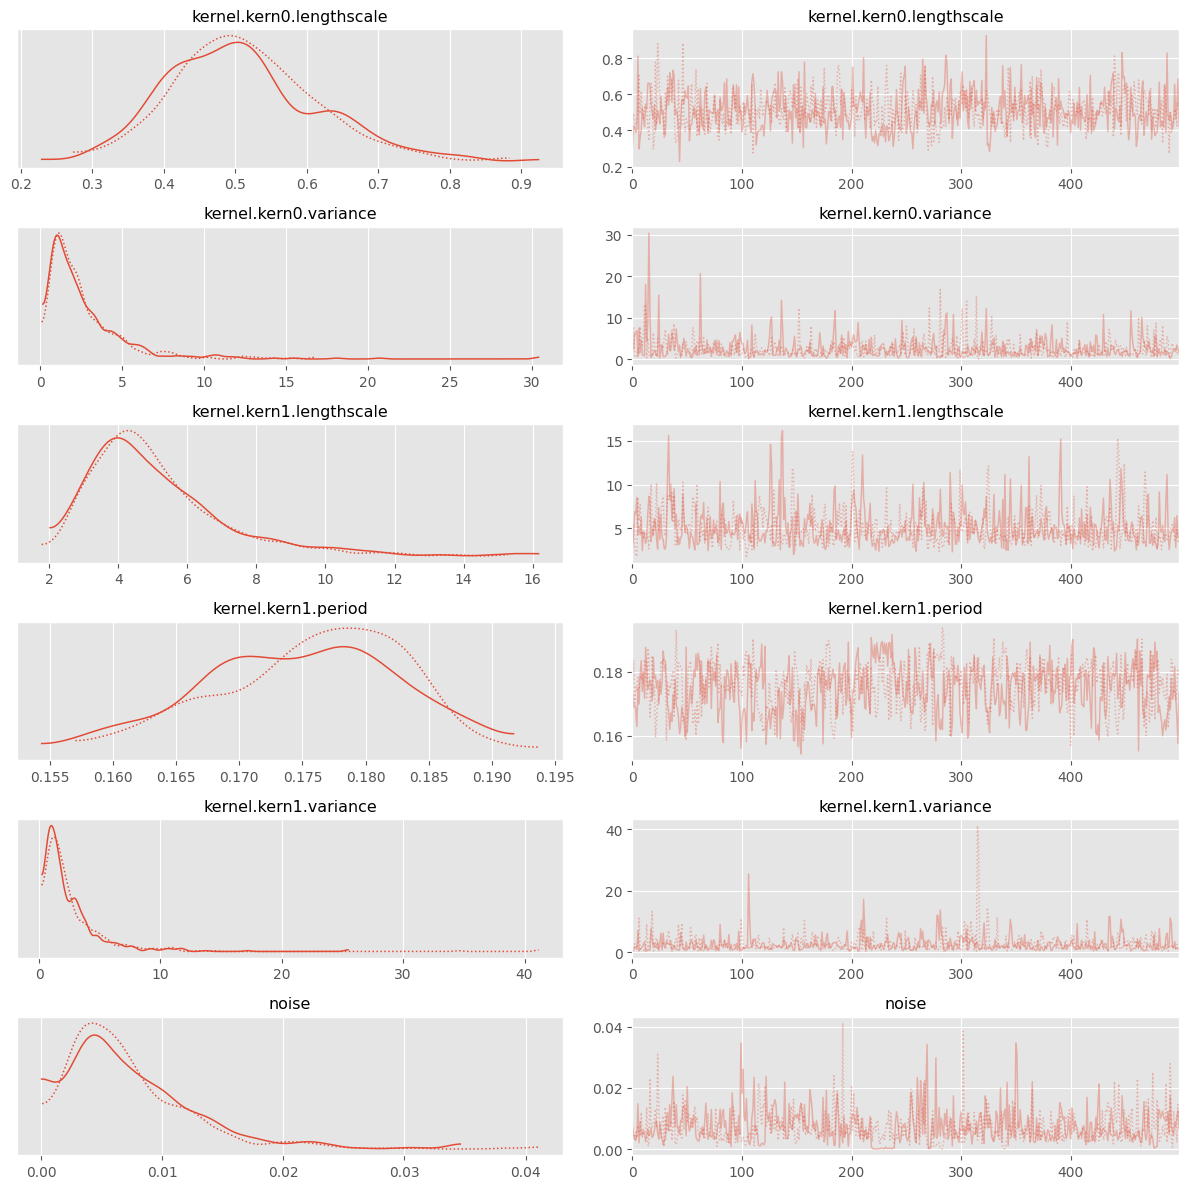

In [106]:
az.plot_trace(data)
plt.tight_layout()
# plt.savefig("arviz_trace.png", dpi=600)


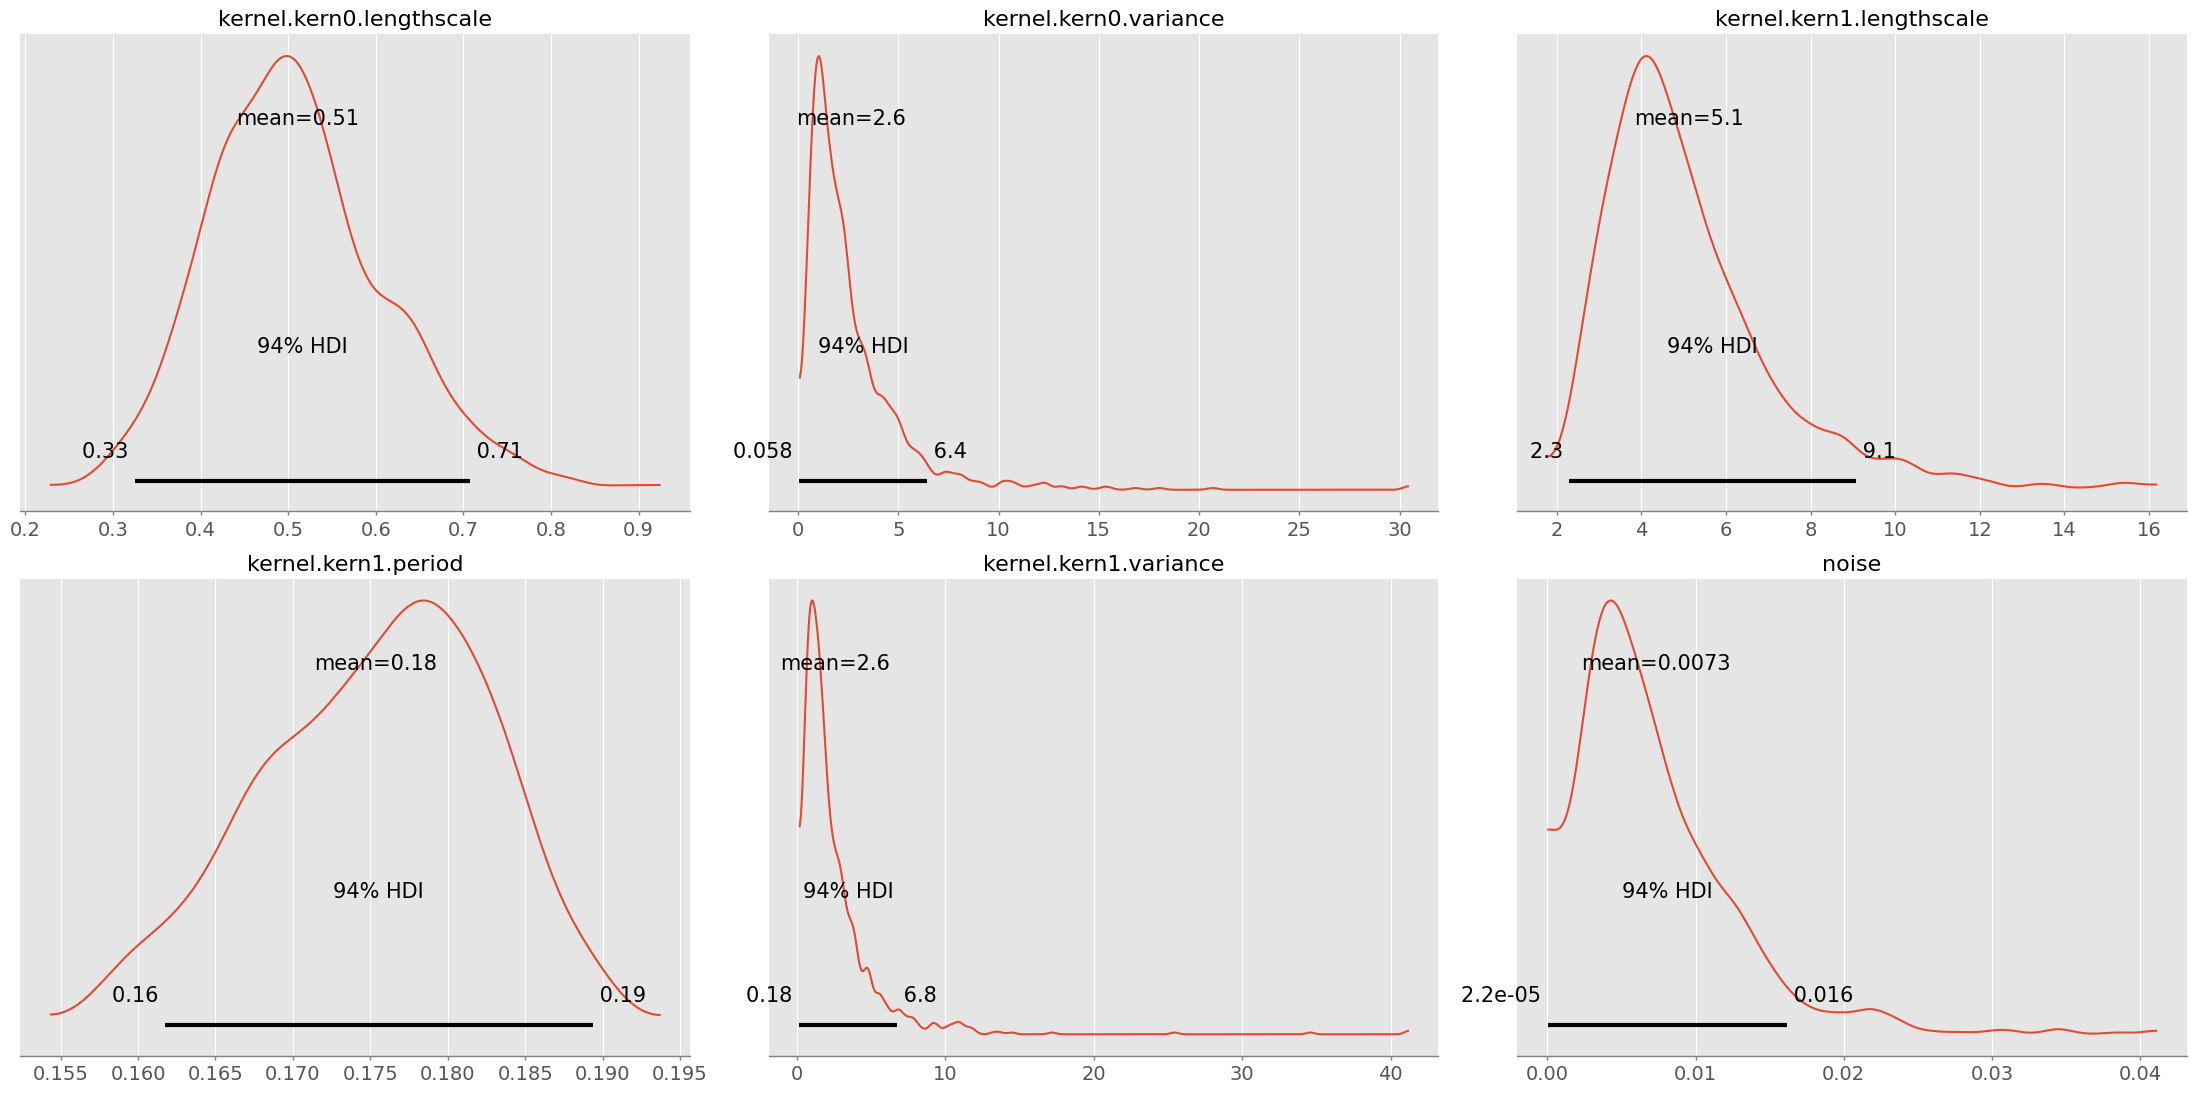

In [107]:
az.plot_posterior(data)
plt.tight_layout()
# plt.savefig("arviz_posterior.png", 6pi=400)


In [108]:
summary = az.summary(data)
summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.kern0.lengthscale,0.511,0.103,0.325,0.707,0.005,0.003,425.0,645.0,1.00
kernel.kern0.variance,2.636,2.548,0.058,6.428,0.096,0.070,778.0,815.0,1.00
kernel.kern1.lengthscale,5.137,2.109,2.300,9.074,0.089,0.064,595.0,726.0,1.00
kernel.kern1.period,0.175,0.008,0.162,0.189,0.000,0.000,266.0,459.0,1.01
kernel.kern1.variance,2.596,2.828,0.179,6.788,0.114,0.085,708.0,561.0,1.00
noise,0.007,0.005,0.000,0.016,0.000,0.000,217.0,88.0,1.00


In [109]:
df = pd.DataFrame(summary)
print(df.to_latex())


\begin{tabular}{lrrrrrrrrr}
\toprule
 & mean & sd & hdi_3% & hdi_97% & mcse_mean & mcse_sd & ess_bulk & ess_tail & r_hat \\
\midrule
kernel.kern0.lengthscale & 0.511000 & 0.103000 & 0.325000 & 0.707000 & 0.005000 & 0.003000 & 425.000000 & 645.000000 & 1.000000 \\
kernel.kern0.variance & 2.636000 & 2.548000 & 0.058000 & 6.428000 & 0.096000 & 0.070000 & 778.000000 & 815.000000 & 1.000000 \\
kernel.kern1.lengthscale & 5.137000 & 2.109000 & 2.300000 & 9.074000 & 0.089000 & 0.064000 & 595.000000 & 726.000000 & 1.000000 \\
kernel.kern1.period & 0.175000 & 0.008000 & 0.162000 & 0.189000 & 0.000000 & 0.000000 & 266.000000 & 459.000000 & 1.010000 \\
kernel.kern1.variance & 2.596000 & 2.828000 & 0.179000 & 6.788000 & 0.114000 & 0.085000 & 708.000000 & 561.000000 & 1.000000 \\
noise & 0.007000 & 0.005000 & 0.000000 & 0.016000 & 0.000000 & 0.000000 & 217.000000 & 88.000000 & 1.000000 \\
\bottomrule
\end{tabular}



In [110]:
mcmc_test_loglikelihoods = []

iterations = 20

for iteration in range(iterations):
    print(f"Iteration {iteration+1} / {iterations}")
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = generate_data()

    # Defining our kernels and GP-model
    rbf = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
    )

    periodic = gp.kernels.Periodic(
        input_dim=1,
        period=torch.tensor(0.5),
        lengthscale=torch.tensor(1.0),
        variance=torch.tensor(1.0),
    )
    kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)

    gpr = gp.models.GPRegression(
        x_train, y_train, kernel=kernel, noise=torch.tensor(0.01)
    )

    # Putting priors on our kernel parameters
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.5, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    # Periodic kernel
    gpr.kernel.kern1.period = pyro.nn.PyroSample(
        dist.LogNormal(torch.log(torch.tensor(1 / 6)), 0.1)
    )
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(1.4, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(1, 100))

    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True, adapt_step_size=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=500)
    mcmc.run()

    posterior_samples = mcmc.get_samples(num_samples=500)

    mcmc_test_loglikelihoods.append(log_likelihood(x_test, y_test, posterior_samples))


Iteration 1 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 2 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Iteration 3 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 4 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 5 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Iteration 6 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 7 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Iteration 8 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 9 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 10 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Iteration 11 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 12 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 13 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Iteration 14 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 15 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Iteration 16 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 17 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 18 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 19 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 20 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


In [111]:
mcmc_test_loglikelihoods = [x.detach().item() for x in mcmc_test_loglikelihoods]
print(mcmc_test_loglikelihoods)


[-10.003376007080078, -10.66156005859375, -9.527608871459961, -15.144512176513672, -10.393901824951172, -9.662750244140625, -9.77433967590332, -18.873714447021484, -11.571853637695312, -16.238658905029297, -10.588781356811523, -11.305194854736328, -10.530559539794922, -9.98822021484375, -9.87820816040039, -10.833829879760742, -12.564215660095215, -9.85630989074707, -10.374197959899902, -10.023008346557617]


In [112]:
map_log_likelihood = [
    -11.739569664001465,
    -10.372503280639648,
    -10.630261421203613,
    -11.856077194213867,
    -18.365325927734375,
    -14.903423309326172,
    -10.197603225708008,
    -10.638860702514648,
    -12.914301872253418,
    -9.359822273254395,
    -10.395574569702148,
    -11.220866203308105,
    -11.83434009552002,
    -9.190084457397461,
    -15.740955352783203,
    -10.94947624206543,
    -10.125082015991211,
    -21.8223934173584,
    -13.305448532104492,
    -14.780899047851562,
]

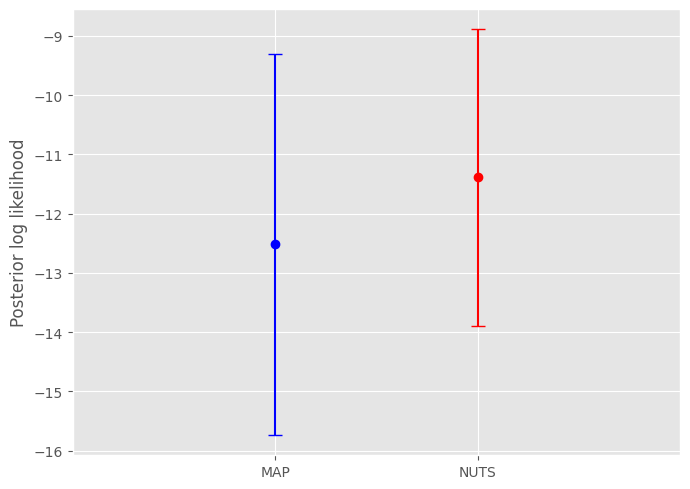

In [113]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(
    1,
    np.mean(map_log_likelihood),
    yerr=np.std(map_log_likelihood, ddof=1),
    fmt="o",
    capsize=5,
    color="blue",
)
ax.errorbar(
    2,
    np.mean(mcmc_test_loglikelihoods),
    yerr=np.std(mcmc_test_loglikelihoods, ddof=1),
    fmt="o",
    capsize=5,
    color="red",
)

ax.set(
    xlim=(0, 3),
    ylabel="Posterior log likelihood",
    xticks=[1, 2],
    xticklabels=["MAP", "NUTS"],
)
plt.tight_layout()
# plt.savefig("./figures/B1_compare_loglikelihood_map_nuts.png", dpi=600)
plt.show()


In [114]:
print("MAP:", np.mean(map_log_likelihood), np.std(map_log_likelihood, ddof=1))
print(
    "NUTS:", np.mean(mcmc_test_loglikelihoods), np.std(mcmc_test_loglikelihoods, ddof=1)
)


MAP: -12.517143440246581 3.2179983436411415
NUTS: -11.389740085601806 2.499808777078688


/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_25239/1537224348.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Method", y="Values", data=df, palette=["red", "blue"], ax=ax)


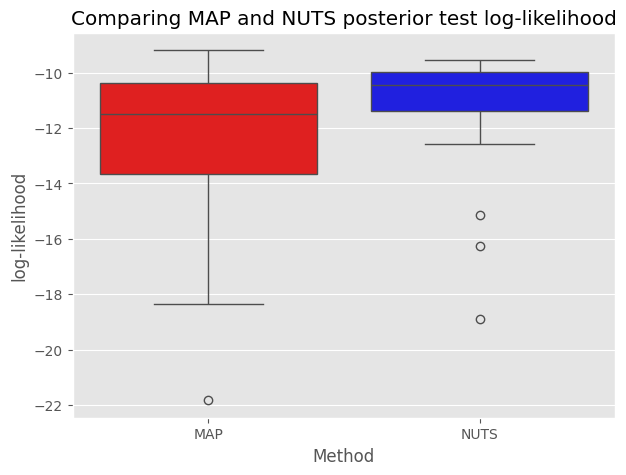

In [118]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(7, 5))

# Combine the arrays into a single DataFrame
df = pd.DataFrame(
    {
        "Values": np.concatenate([map_log_likelihood, mcmc_test_loglikelihoods]),
        "Method": ["MAP"] * len(map_log_likelihood)
        + ["NUTS"] * len(mcmc_test_loglikelihoods),
    }
)

# Create the boxplot
sns.boxplot(x="Method", y="Values", data=df, palette=["red", "blue"], ax=ax)
ax.set_title("Comparing MAP and NUTS posterior test log-likelihood")
ax.set_ylabel("log-likelihood")
plt.savefig("./figures/compare_loglikelihood_map_nuts_boxplot.png", dpi=600)
plt.show()